In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 1. Load CSVs
qualifying = pd.read_csv('/content/qualifying.csv')
races = pd.read_csv('/content/races.csv')
drivers = pd.read_csv('/content/drivers.csv')
constructors = pd.read_csv('/content/constructors.csv')
driver_standings = pd.read_csv('/content/driver_standings.csv')
constructor_standings = pd.read_csv('/content/constructor_standings.csv')

In [4]:
# 2. Merge qualifying with races
qual = qualifying.merge(races, on='raceId')
qual = qual[qual['name'].str.contains("Japan")]

In [5]:
# 3. Merge with driver info
qual = qual.merge(drivers, on='driverId')

In [6]:
# 4. Merge with constructors
qual = qual.merge(constructors, on='constructorId')

In [7]:
# 5. Add driver standings for that race
qual = qual.merge(driver_standings, on=['raceId', 'driverId'])

In [8]:
# 6. Add constructor standings
qual = qual.merge(constructor_standings, on=['raceId', 'constructorId'])

In [38]:
# Now select relevant features and train your Linear Regression model
features = ['constructor_points', 'avg_last5_qual_pos', 'avg_last5_race_pos', 'suzuka_best_pos']  # driver & constructor points and ranks
target = 'position'

In [39]:
target

'position'

In [42]:
# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
X

,points_x,position_x,points_y,position_y
0,84.0,1,135.0,1
1,63.0,2,142.0,4
2,51.0,3,135.0,6
3,48.0,4,66.0,7
4,79.0,5,142.0,2
...,...,...,...,...
509,9.0,16,33.0,10
510,0.0,17,0.0,19
511,1.0,18,4.0,14
512,0.0,19,0.0,21


In [16]:
y

,position
0,2
1,1
2,2
3,4
4,1
...,...
509,5
510,10
511,7
512,8


In [17]:
X_train

,points_x,position_x,points_y,position_y
320,0.0,13,1.0,18
329,0.0,22,0.0,19
173,0.0,24,0.0,31
272,4.0,13,5.0,17
493,0.0,20,21.0,20
...,...,...,...,...
106,67.0,3,153.0,3
270,28.0,11,48.0,11
348,0.0,19,0.0,18
435,223.0,2,435.0,3


In [19]:
# Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [20]:
# Predict
y_pred = model.predict(X_test)

In [24]:
# Evaluate
print(" RMSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


 RMSE: 1.761730609183071
R² Score: 0.8021740507544275


In [34]:
# 10. Predict on new input (example for 2025 Japan GP)
japan_gp_input = pd.DataFrame({
    'points_x': [180],      # driver points
    'position_x': [2],      # driver rank
    'points_y': [220],      # constructor points
    'position_y': [1]       # constructor rank
})



In [36]:
japan_pred = model.predict(japan_gp_input)
print("\n Predicted Qualifying Position for Japan GP:", round(japan_pred[0], 2))


 Predicted Qualifying Position for Japan GP: 3.34


In [43]:
# Filter Japan GP (latest one)
japan_race = races[races['name'].str.contains("Japan", case=False)].sort_values('year', ascending=False).iloc[0]
japan_race_id = japan_race['raceId']

In [44]:
# Merge qualifying with Japan GP only
qual = qualifying[qualifying['raceId'] == japan_race_id]
qual = qual.merge(drivers, on='driverId')
qual = qual.merge(constructors, on='constructorId')
qual = qual.merge(driver_standings, on=['raceId', 'driverId'], suffixes=('', '_driver'))
qual = qual.merge(constructor_standings, on=['raceId', 'constructorId'], suffixes=('', '_constructor'))

In [45]:
# Clean: drop missing values
qual = qual.dropna(subset=['points', 'position', 'points_constructor', 'position_constructor'])

In [46]:
# Rename for clarity
qual = qual.rename(columns={
    'points': 'driver_points',
    'position': 'driver_position',
    'points_constructor': 'constructor_points',
    'position_constructor': 'constructor_position'
})

In [49]:

# Handle any naming issues after renaming
if 'points_constructor' not in qual.columns:
    qual = qual.rename(columns={'points_constructor': 'constructor_points'})
if 'position_constructor' not in qual.columns:
    qual = qual.rename(columns={'position_constructor': 'constructor_position'})



In [54]:
# If you have 'q1' or 'q3' time data
qual['qualifying_time'] = qual[['q1', 'q2', 'q3']].min(axis=1)
qual = qual.dropna(subset=['qualifying_time'])

# Use qualifying time to simulate position
qual = qual.sort_values('qualifying_time')
qual['qual_position'] = range(1, len(qual)+1)

# Now use it as target
y = qual['qual_position']


In [55]:
y

,qual_position
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [56]:
x=qual[['driver_points', 'driver_position', 'constructor_points', 'constructor_position']]

In [57]:
# Train model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [60]:
# Merge with constructors and rename the name column right after
qual = qual.merge(constructors[['constructorId', 'name']], on='constructorId')
qual = qual.rename(columns={'name': 'constructor_name'})


In [61]:
print(qual.columns.tolist())


['qualifyId', 'raceId', 'driverId', 'constructorId', 'number_x', 'driver_position', 'q1', 'q2', 'q3', 'driverRef', 'number_y', 'code', 'forename', 'surname', 'dob', 'nationality_x', 'url_x', 'constructorRef', 'name_x', 'nationality_y', 'url_y', 'driverStandingsId', 'driver_points', 'position_driver', 'positionText', 'wins', 'constructorStandingsId', 'constructor_points', 'constructor_position', 'positionText_constructor', 'wins_constructor', 'qualifying_time', 'qual_position', 'name_y']


In [62]:
qual = qual.rename(columns={'name_y': 'constructor_name'})  # if it exists


In [63]:
# Predict for all drivers
predictions = []
for idx, row in qual.iterrows():
    input_data = pd.DataFrame([{
        'driver_points': row['driver_points'],
        'driver_position': row['driver_position'],
        'constructor_points': row['constructor_points'],
        'constructor_position': row['constructor_position']
    }])
    predicted_pos = model.predict(input_data)[0]
    predictions.append({
        'driver': f"{row['forename']} {row['surname']}",
        'constructor': row['constructor_name'],  # 🔁 Updated here!
        'predicted_position': round(predicted_pos, 2)
    })


In [64]:
# Show final predicted grid
pred_df = pd.DataFrame(predictions)
pred_df = pred_df.sort_values(by='predicted_position').reset_index(drop=True)

In [65]:
print("\n Predicted Qualifying Grid for Japan GP:\n")
for i, row in pred_df.iterrows():
    print(f"P{i+1}: {row['driver']} ({row['constructor']}) - Predicted Pos: {row['predicted_position']}")


🏁 Predicted Qualifying Grid for Japan GP:

P1: Max Verstappen (Red Bull) - Predicted Pos: 1.0
P2: Sergio Pérez (Red Bull) - Predicted Pos: 2.0
P3: Lando Norris (McLaren) - Predicted Pos: 3.0
P4: Carlos Sainz (Ferrari) - Predicted Pos: 4.0
P5: Fernando Alonso (Aston Martin) - Predicted Pos: 5.0
P6: Oscar Piastri (McLaren) - Predicted Pos: 6.0
P7: Lewis Hamilton (Mercedes) - Predicted Pos: 7.0
P8: Charles Leclerc (Ferrari) - Predicted Pos: 8.0
P9: George Russell (Mercedes) - Predicted Pos: 9.0
P10: Yuki Tsunoda (RB F1 Team) - Predicted Pos: 10.0
P11: Daniel Ricciardo (RB F1 Team) - Predicted Pos: 11.0
P12: Nico Hülkenberg (Haas F1 Team) - Predicted Pos: 12.0
P13: Valtteri Bottas (Sauber) - Predicted Pos: 13.0
P14: Alexander Albon (Williams) - Predicted Pos: 14.0
P15: Esteban Ocon (Alpine F1 Team) - Predicted Pos: 15.0
P16: Lance Stroll (Aston Martin) - Predicted Pos: 16.0
P17: Pierre Gasly (Alpine F1 Team) - Predicted Pos: 17.0
P18: Kevin Magnussen (Haas F1 Team) - Predicted Pos: 18.0
P

In [66]:
# Sort by predicted position
predictions_sorted = sorted(predictions, key=lambda x: x['predicted_position'])

# Display Top 10
for i, p in enumerate(predictions_sorted[:10], start=1):
    print(f"P{i}: {p['driver']} ({p['constructor']}) - Predicted Pos: {p['predicted_position']}")


P1: Max Verstappen (Red Bull) - Predicted Pos: 1.0
P2: Sergio Pérez (Red Bull) - Predicted Pos: 2.0
P3: Lando Norris (McLaren) - Predicted Pos: 3.0
P4: Carlos Sainz (Ferrari) - Predicted Pos: 4.0
P5: Fernando Alonso (Aston Martin) - Predicted Pos: 5.0
P6: Oscar Piastri (McLaren) - Predicted Pos: 6.0
P7: Lewis Hamilton (Mercedes) - Predicted Pos: 7.0
P8: Charles Leclerc (Ferrari) - Predicted Pos: 8.0
P9: George Russell (Mercedes) - Predicted Pos: 9.0
P10: Yuki Tsunoda (RB F1 Team) - Predicted Pos: 10.0


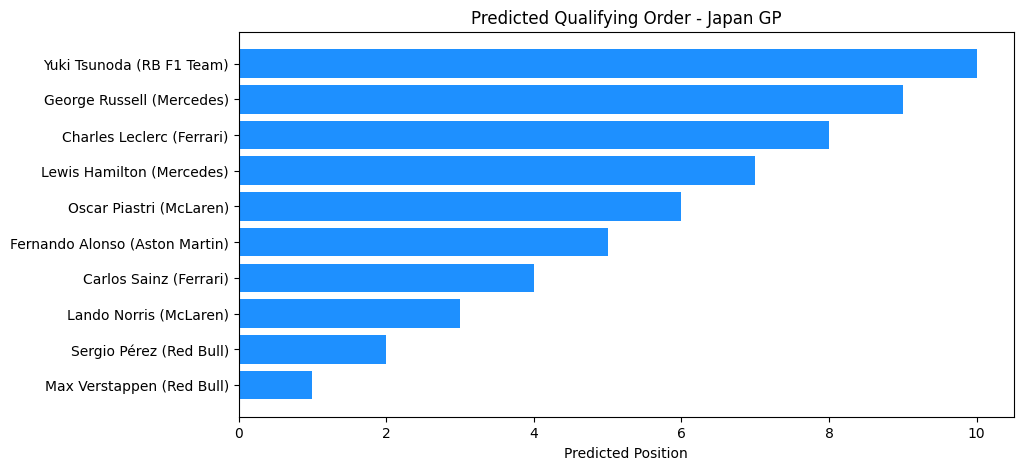

In [67]:
import matplotlib.pyplot as plt

drivers = [f"{p['driver']} ({p['constructor']})" for p in predictions_sorted[:10]]
positions = [p['predicted_position'] for p in predictions_sorted[:10]]

plt.figure(figsize=(10, 5))
plt.barh(drivers[::-1], positions[::-1], color='dodgerblue')
plt.xlabel("Predicted Position")
plt.title("Predicted Qualifying Order - Japan GP")
plt.gca().invert_yaxis()
plt.show()
